In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.append('/home/wtim/neural-capability-maps/')

In [4]:
import torch
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

import data_sampling.se3 as se3
from data_sampling.sample_morph import sample_morph
from data_sampling.representations import rotation_matrix_to_rotation_vector, homogeneous_to_vector
from data_sampling.sample_capability_map import sample_capability_map_analytically, sample_capability_map, estimate_capability_map
from data_sampling.robotics import analytical_inverse_kinematics

from neural_capability_maps.logger import calculate_metrics
from tests.visualisation import visualise, visualise_workspace, visualise_predictions

In [5]:
torch.manual_seed(1)

In [6]:
morphs = [sample_morph(1, i, True)[0] for i in range(6, 7)]

In [15]:
discretisation_labels = []
discretisation_cell_indices = []
for morph in morphs:
    cell_indices, labels = sample_capability_map(morph, 100_000)

    discretisation_labels += [labels.bool()]
    discretisation_cell_indices += [cell_indices]

[auto-batch] est. bytes/sample: 20838 (20.35 KiB), free: 26.26 GiB, safety: 0.5, batch_size: 676489
[auto-batch] est. bytes/sample: 21246 (20.75 KiB), free: 26.28 GiB, safety: 0.5, batch_size: 663992
79.0


In [16]:
tp = []
tn = []
fp = []
fn = []
acc = []
ground_truth = []
poses = []
for label, cell_indices in zip(discretisation_labels, discretisation_cell_indices):
    ground_truth += [torch.zeros_like(label)]
    poses += [torch.zeros(label.shape[0], 4, 4)]
    for i in range(0, label.shape[0], 100_000):
        poses[-1][i:i + 100_000] = se3.cell(cell_indices[i:i + 100_000])
        _, manipulability = analytical_inverse_kinematics(morphs[-1], poses[-1][i:i + 100_000])
        ground_truth[-1][i:i + 100_000] = manipulability.cpu() != -1

    true_positives, true_negatives, false_positives, false_negatives, accuracy = calculate_metrics(label, ground_truth[-1])
    tp += [true_positives]
    tn += [true_negatives]
    fp += [false_positives]
    fn += [false_negatives]
    acc += [accuracy]

headers = ["True Positives", "True Negatives", "False Positives", "False Negatives", "Accuracy"]
table = list(zip(tp, tn, fp, fn, acc))
print(tabulate(table, headers=headers, floatfmt=".2f"))

  True Positives    True Negatives    False Positives    False Negatives    Accuracy
----------------  ----------------  -----------------  -----------------  ----------
           69.39             91.91               8.09              30.61       80.65


In [17]:
visualise_predictions(morphs, poses, discretisation_labels, ground_truth)

# Qualitative Analysis

## Generate Test Poses

In [18]:
num_geodesics = 3
line_samples = 5000

directions = se3.random(num_geodesics)

batched_origin = torch.eye(4).repeat(num_geodesics, 1, 1)
axis_angle = rotation_matrix_to_rotation_vector(directions[:, :3, :3])
flat_pose = torch.cat([axis_angle, directions[:, :3, 3]], dim=1) / se3.distance(directions, batched_origin)
flat_pose /= flat_pose[:, 3:].norm(dim=1, keepdim=True)

t = torch.arange(0, 1, 1 / line_samples).repeat(num_geodesics, 1)
lines = t.unsqueeze(2) * flat_pose.unsqueeze(1)

line_poses = torch.eye(4).repeat(num_geodesics, line_samples, 1, 1)
line_poses[:, :, :3, :3] = Rotation.from_rotvec(lines[:, :, :3].reshape(-1, 3)).as_matrix().reshape(*lines[:, :, :3].shape[0:2], 3, 3)
line_poses[:, :, :3, 3] = lines[:, :, 3:]

## Generate Ground-Truth

In [21]:
manipulability = analytical_inverse_kinematics(morphs[-1], line_poses.view(-1, 4, 4))[1].reshape(num_geodesics, line_samples)
ground_truth_line = manipulability != -1

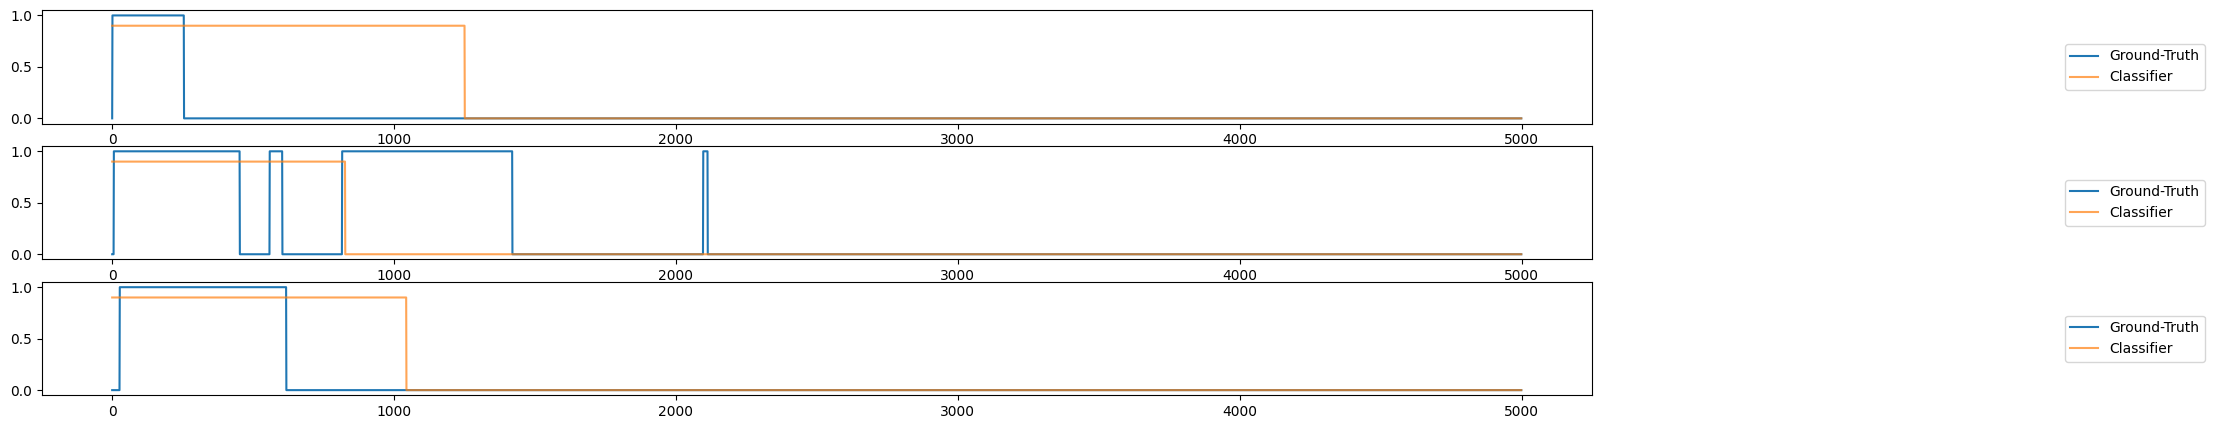

In [43]:
# Plot
fig, axes = plt.subplots(num_geodesics, figsize=(20, 5))

for i in range(num_geodesics):
    axes[i].plot(ground_truth_line[i], label="Ground-Truth")
    axes[i].plot(line_pred[i]*0.9, label="Classifier", alpha=0.7)
    axes[i].legend(loc="right", bbox_to_anchor=(1.4, 0.5))
plt.show()